In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [3]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[3]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# model

In [4]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [5]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [29]:
learning_rate = 0.1
bins = 2
lam = 3
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 5
tolerance = 0.01


total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
eg.initialize_nodes(log_odds,p)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()
stack.extend(eg.nodes)
losses.extend(origin_losses)

for i in range(100):
    for j in range(6):
        eg.evolve(total_size,elite_size,log_odds=log_odds,p=p,tolerance=tolerance,verbose=0)
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes[num_features:],tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),sum([n.numNode for n in stack]),i)
    # if len(stack) > 8000:
    #         break


26 46 0
31 61 1
33 67 2
40 112 3
43 111 4
44 116 5
52 168 6
55 177 7
58 182 8


KeyboardInterrupt: 

0.9584143968871596 0.9500850822461713 0.9534883720930233
434.7282877695312 207.40421034060563 207.40421034060563
0.9868677042801557 0.975609756097561 0.9767441860465116
228.40403676361842 123.64752522750717 123.6461308624209
0.9931906614785992 0.979013045944413 0.9807146908678389
145.51612806067405 89.97224613224381 89.95698132566525
0.9953793774319066 0.9852524106636416 0.9852524106636416
101.61621652640423 71.75088867370508 71.72651607488281
0.9968385214007782 0.9880884855360181 0.9880884855360181
75.45790861081699 60.766875310042394 60.7443405676955
0.997568093385214 0.9875212705615428 0.9880884855360181
58.48049392934953 53.49152157323263 53.47953220180207
0.9978112840466926 0.9886557005104935 0.9892229154849688
46.7383231589937 48.52116486242434 48.51292343963253
0.9985408560311284 0.9886557005104935 0.9892229154849688
38.24667782094938 44.994983852246264 44.96749301274009
0.998784046692607 0.9880884855360181 0.9892229154849688
31.88357520896083 42.204249282039314 42.1615288889937

KeyboardInterrupt: 

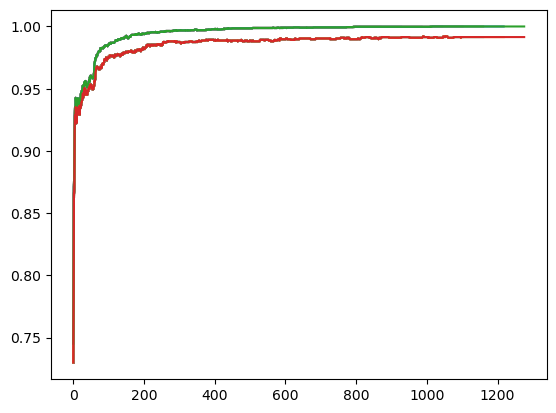

In [30]:
def training_data(node,y_train_one_hot,log_odds,p,test_log_odds=None,test_p=None):
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    if test_log_odds != None:
        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)

        return log_odds,p,test_log_odds,test_p
    
    return log_odds,p

def get_order(stack,y_train_one_hot,log_odds,p,previous_sse):
    score = []
    
    for node in stack:
        log_odds,p = training_data(node,y_train_one_hot,log_odds,p)
        
        sse = np.sum(np.power(y_train_one_hot - p,2))
        score.append(previous_sse - sse)
        previous_sse = sse
    
    return [stack[i] for i in np.argsort(score)[::-1]]

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

# a = get_order(a,y_train_one_hot,log_odds,p,previous_sse=np.sum(np.power(y_train_one_hot - p,2)))

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []

for _ in range(200):
    score = []
    
    for i,node in enumerate(a):
        # node.estimator.lam = 3
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


        train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
        # score.append(previous_sse - train_sse[-1])
        # previous_sse = train_sse[-1]


        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(pred,y_train))
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(test_pred,y_test))
    
    # a = [a[i] for i in np.argsort(score)[::-1]]

    plt.plot(train_acc)
    plt.plot(test_acc)
    print(train_acc[-1],test_acc[-1],max(test_acc))

    # plt.plot(train_sse)
    # plt.plot(test_sse)
    print(train_sse[-1],test_sse[-1],min(test_sse))

    # plt.legend(["train","test"])
    # plt.show()
    

In [22]:
sum([n.numNode for n in stack])

261

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      2825
           1    1.00000   1.00000   1.00000      1287

    accuracy                        1.00000      4112
   macro avg    1.00000   1.00000   1.00000      4112
weighted avg    1.00000   1.00000   1.00000      4112

              precision    recall  f1-score   support

           0    0.99408   0.99324   0.99366      1183
           1    0.98623   0.98793   0.98708       580

    accuracy                        0.99149      1763
   macro avg    0.99015   0.99058   0.99037      1763
weighted avg    0.99150   0.99149   0.99149      1763



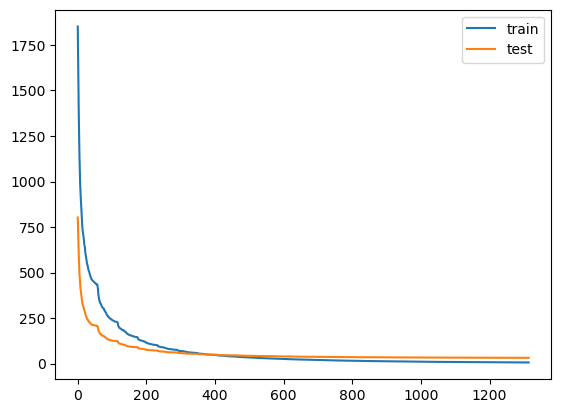

In [31]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2825
           1       1.00      1.00      1.00      1287

    accuracy                           1.00      4112
   macro avg       1.00      1.00      1.00      4112
weighted avg       1.00      1.00      1.00      4112

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1183
           1       0.87      0.90      0.88       580

    accuracy                           0.92      1763
   macro avg       0.91      0.92      0.91      1763
weighted avg       0.92      0.92      0.92      1763



# XGBoost

In [16]:
import xgboost


In [17]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      2825
           1    1.00000   1.00000   1.00000      1287

    accuracy                        1.00000      4112
   macro avg    1.00000   1.00000   1.00000      4112
weighted avg    1.00000   1.00000   1.00000      4112

              precision    recall  f1-score   support

           0    0.99662   0.99746   0.99704      1183
           1    0.99482   0.99310   0.99396       580

    accuracy                        0.99603      1763
   macro avg    0.99572   0.99528   0.99550      1763
weighted avg    0.99603   0.99603   0.99603      1763

train: 0.3874010302970268
test: 11.105673462150788


(100, 5.82, 3126)

# GDBT

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len(clf.estimators_),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

              precision    recall  f1-score   support

           0    0.97331   0.99398   0.98354      2825
           1    0.98615   0.94017   0.96261      1287

    accuracy                        0.97714      4112
   macro avg    0.97973   0.96708   0.97307      4112
weighted avg    0.97733   0.97714   0.97699      4112

              precision    recall  f1-score   support

           0    0.95727   0.98478   0.97083      1183
           1    0.96703   0.91034   0.93783       580

    accuracy                        0.96029      1763
   macro avg    0.96215   0.94756   0.95433      1763
weighted avg    0.96048   0.96029   0.95998      1763

train: 248.66207971720107
test: 143.64247665003924


(100, 1494)